<details>
<summary>Variables</summary>
<br>
Data point

<ul>
<li>longitude - horizontal coordinates: 0.0658</li>
<li>latitude - vertical coordinates: 0.0341</li>
<li>time - datetime as timestamp</li>

Pressure level (from upper troposphere, primary data)
<li>d - divergence: 0.0208</li>
<li>cc - fraction of cloud cover - %: 0.1779</li>
<li>z - geopotential - m/s?: 0.5817</li>
<li>o3 - ozone mass mixing ratio - kg: -0.3365</li>
<li>pv - potential vorticity: 0.0709</li>
<li>r - relative humidity - %: 0.2829</li>
<li>ciwc - cloud ice water content - kg: 0.4201</li>

This is what I have to predict
<li>q - specific humidity - kg</li>
<li>cswc - cloud snow water content - kg: 0.4252</li>
<li>t - temperature - Kelvin: 0.6219</li>
<li>u - eastward wind - m/s: -0.0637</li>
<li>v - northward wind - m/s: 0.0742</li>
<li>w - vertical velocity - Pa/s: -0.2006</li>
<li>vo - vorticity: -0.0122</li>

Surface level (secondary data)
<li>u10 - 10m eastward wind - m/s: -0.0416</li>
<li>v10 - 10m northward wind - m/s: -0.0398</li>
<li>d2m - 2m dewpoint temperature - Kelvin: 0.5117</li>
<li>fal - Forecast albedo - 0-1: -0.4423</li>
<li>lai_hv - Leaf area index high vegetation: 0.4315</li>
<li>lai_lv - Leaf area index low vegetation: 0.2420</li>
<li>pev - Potential evaporation - m: -0.1723</li>
<li>ro - Runoff - m: 0.3770</li>
<li>skt - Skin temperature - Kelvin: 0.4425</li>
<li>ssr - Surface net solar radiation - Joules/m^2: 0.1212</li>
<li>sp - Surface pressure - Pa: 0.2366</li>
<li>e - Total evaporation - m: -0.3412</li>
<li>tp - Total precipitation - m: 0.3490</li>
</ul>
</details>

In [ ]:
#setup
!pip install pycontrails

import pandas as pd
import xarray as xr
import numpy as np
import lightgbm as lgb
import pycontrails
import seaborn as sns
import matplotlib.pyplot as plt
import importlib.util
import gc

from pycontrails import Flight
from pycontrails.models.cocip import Cocip
from pycontrails import MetDataset, MetDataArray, MetVariable
from pycontrails.models.sac import SAC
from pycontrails.models.issr import ISSR

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
dataFrame = None

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.0 MB/s eta 0:00:00
Mounted at /content/gdrive/


In [ ]:
#close vscode CSV viewer before running these functions
def loadCSV(toLoad):
  try:
    if toLoad == 'raw':
      return pd.read_csv('/content/gdrive/MyDrive/Convex/Saved Data/rawDataset.csv')
    elif toLoad == 'processed':
      return pd.read_csv('/content/gdrive/MyDrive/Convex/Saved Data/processedDataset.csv')
    else:
      return pd.read_csv('/content/gdrive/MyDrive/Convex/Saved Data/lastDataset.csv')
  except:
    print('CSV not saved yet')
def updateCSV(toUpdate):
  if toUpdate == 'raw':
    dataFrame.to_csv('/content/gdrive/MyDrive/Convex/Saved Data/rawDataset.csv', index=False)
  elif toUpdate == 'processed':
    dataFrame.to_csv('/content/gdrive/MyDrive/Convex/Saved Data/processedDataset.csv', index=False)
  else:
    dataFrame.to_csv('/content/gdrive/MyDrive/Convex/Saved Data/lastDataset.csv', index=False)


In [ ]:
#load raw CSV instead of converting nc to csv again
dataFrame = loadCSV('raw')

In [ ]:
#load processed CSV to save time
dataFrame = loadCSV('processed')

In [ ]:
features = dataFrame.columns.to_list()
# avoid using rates of change of below values
avoidRate = np.array(['ciwc', 'cswc', 'tp', 'ssr', 'ro', 'cc'])
# avoid using below values completely
avoidAll = np.array(['longitude', 'latitude', 'time', 'lai_hv', 'lai_lv'])

In [ ]:
rateValues = pd.DataFrame(columns=(np.char.add((np.setdiff1d(features, np.concatenate((avoidRate, avoidAll)), True)), 'Rate')))
newValues = pd.DataFrame(columns=(np.concatenate(((np.char.add((np.setdiff1d(features, avoidAll, True)), 'New')), ['qValid', 'tValid']))))

In [ ]:
dataFrame = pd.merge(xr.open_dataset('/content/gdrive/MyDrive/Convex/Datasets/era5SurfaceLegacy.nc').to_dataframe().reset_index(drop=False), xr.open_dataset('/content/gdrive/MyDrive/Convex/Datasets/era5PressureLegacy.nc').to_dataframe().reset_index(drop=False), on=['longitude', 'latitude', 'time'], how='inner').dropna()
dataFrame.drop('clwc', axis=1, inplace=True)
dataFrame.drop('crwc', axis=1, inplace=True)
updateCSV('raw')

KeyboardInterrupt: 

In [ ]:
# define date range for rate of change, as well as date to predict

# period for rate of change
ratePeriod = 2
# period for prediction (max 1 week)
predPeriod = 1
dataFrame['time'] = pd.to_datetime(dataFrame['time'])
beforeDataFrame = dataFrame.loc[(dataFrame['time'].dt.day == 1) & (dataFrame['time'].dt.hour != 10)]

In [ ]:
#parse dataset, do not run unless if making changes
#count = 0

#loop through rows of beforeDataFrame, used as reference
for index, row in beforeDataFrame.iterrows():

    #count += 1
    #print(count)

    queuedRates = []
    queuedNew = []

    #since script is run for each feature, flag is set to avoid triggering twice per row
    flag = True

    #set long and lat variables
    long = row['longitude']
    lat = row['latitude']

    #& (dataFrame['time'].dt.hour == hour) add this later
    #set lag and valid for row
    lag = dataFrame.loc[(dataFrame['longitude'] == long) & (dataFrame['latitude'] == lat) & (dataFrame['time'].dt.day == (1 + ratePeriod))].iloc[0]
    valid = dataFrame.loc[(dataFrame['longitude'] == long) & (dataFrame['latitude'] == lat) & (dataFrame['time'].dt.day == (1 + ratePeriod + predPeriod))].iloc[0]

    #loop through features
    for feature in dataFrame.columns:
        if flag == True and feature not in avoidRate and feature not in avoidAll:
            # check to prevent divide by zero error (0 value one day, non-0 next day)
            if row[feature] == 0 and lag[feature] != 0 or row[feature] != 0 and lag[feature] == 0:
                beforeDataFrame = beforeDataFrame.drop(row.name)
                flag = False
            else:
                if row[feature] == lag[feature]:
                    rateOfChange = 0
                else:
                    rateOfChange = (lag[feature] - row[feature]) / row[feature]
                queuedRates.append(rateOfChange)
        if feature not in avoidAll:
            queuedNew.append(lag[feature])
    if flag == True:
        queuedNew.append(valid['q'])
        queuedNew.append(valid['t'])
        rateValues.loc[len(rateValues)] = queuedRates
        newValues.loc[len(newValues)] = queuedNew

KeyboardInterrupt: 

In [ ]:
dataFrame = pd.concat([beforeDataFrame.reset_index(drop=True), newValues.reset_index(drop=True), rateValues.reset_index(drop=True)], axis=1)
updateCSV('processed')

NameError: name 'beforeDataFrame' is not defined

In [ ]:
results = pd.DataFrame(columns=['humidityPred', 'humidityValid', 'tempPred', 'tempValid', 'longitude', 'latitude'])

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 80,
    'min_data_in_leaf': 20,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'max_depth': 16,
    'learning_rate': 0.07,
}

In [ ]:
#decide which variables to use and split dataset
#first train model for humidity
X = dataFrame[['q', 'd2mNew', 'falNew', 'pevNew', 'roNew', 'sktNew', 'ssrNew', 'spNew', 'eNew', 'tpNew', 'dNew', 'ccNew', 'zNew', 'o3New', 'pvNew', 'rNew', 'ciwcNew', 'qNew', 'cswcNew', 'tNew', 'uNew', 'vNew', 'wNew', 'voNew', 'lai_hv', 'lai_lv', 'eRate', 'dRate', 'zRate', 'o3Rate', 'pvRate', 'rRate', 'qRate', 'tRate', 'uRate', 'vRate', 'wRate', 'voRate']]
y = dataFrame[['qValid', 'longitude', 'latitude']]
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)
testLong = y_test['longitude']
testLat = y_test['latitude']
y_train = y_train.drop(['longitude', 'latitude'], axis=1)
y_test = y_test.drop(['longitude', 'latitude'], axis=1)
results['longitude'] = testLong
results['latitude'] = testLat

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

In [ ]:
rounds = 2100
bstHumidity = lgb.train(params, lgb_train, rounds, valid_sets=[lgb_test])

y_pred = bstHumidity.predict(X_test)
# Evaluate the results
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Humidity RMSE: {rmse}")
print(f"Humidity MAE: {mae}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9564
[LightGBM] [Info] Number of data points in the train set: 62053, number of used features: 38
[LightGBM] [Info] Start training from score 0.000091
Humidity RMSE: 3.075434588488426e-05
Humidity MAE: 1.2278346206210522e-05


In [ ]:
results['humidityPred'] = y_pred
results['humidityValid'] = y_test['qValid'].values

In [ ]:
#now train model for temperature
X = dataFrame[['t', 'd2mNew', 'falNew', 'pevNew', 'roNew', 'sktNew', 'ssrNew', 'spNew', 'eNew', 'tpNew', 'dNew', 'ccNew', 'zNew', 'o3New', 'pvNew', 'rNew', 'ciwcNew', 'qNew', 'cswcNew', 'tNew', 'uNew', 'vNew', 'wNew', 'voNew', 'lai_hv', 'lai_lv', 'eRate', 'dRate', 'zRate', 'o3Rate', 'pvRate', 'rRate', 'qRate', 'tRate', 'uRate', 'vRate', 'wRate', 'voRate']]
y = dataFrame[['tValid']]
#will return same data points because of same random_state
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

In [ ]:
rounds = 2100
bstTemp = lgb.train(params, lgb_train, rounds, valid_sets=[lgb_test])

y_pred = bstTemp.predict(X_test)
# Evaluate the results
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Temperature RMSE: {rmse}")
print(f"Temperature MAE: {mae}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9564
[LightGBM] [Info] Number of data points in the train set: 62053, number of used features: 38
[LightGBM] [Info] Start training from score 225.801432
Temperature RMSE: 0.33565885153644387
Temperature MAE: 0.2136108465903069


In [ ]:
results['tempPred'] = y_pred
results['tempValid'] = y_test['tValid'].values

In [ ]:
#load processed CSV again, if performing grid operation on specific area (e.g Great Lakes)
dataFrame = loadCSV('processed')
dataFrame['time'] = pd.to_datetime(dataFrame['time'])

In [ ]:
#grid operation on local area, don't run otherwise
latRange = [20, 35]
longRange = [0, 65]

#remove first statement if running on all timestamps
dataFrame = dataFrame.loc[(dataFrame['longitude'] >= longRange[0]) & (dataFrame['longitude'] <= longRange[1]) & (dataFrame['latitude'] >= latRange[0]) & (dataFrame['latitude'] <= latRange[1])].drop(columns=['time'])

localHumidityPred = bstHumidity.predict(dataFrame[['q', 'd2mNew', 'falNew', 'pevNew', 'roNew', 'sktNew', 'ssrNew', 'spNew', 'eNew', 'tpNew', 'dNew', 'ccNew', 'zNew', 'o3New', 'pvNew', 'rNew', 'ciwcNew', 'qNew', 'cswcNew', 'tNew', 'uNew', 'vNew', 'wNew', 'voNew', 'lai_hv', 'lai_lv', 'eRate', 'dRate', 'zRate', 'o3Rate', 'pvRate', 'rRate', 'qRate', 'tRate', 'uRate', 'vRate', 'wRate', 'voRate']])
localTempPred = bstTemp.predict(dataFrame[['t', 'd2mNew', 'falNew', 'pevNew', 'roNew', 'sktNew', 'ssrNew', 'spNew', 'eNew', 'tpNew', 'dNew', 'ccNew', 'zNew', 'o3New', 'pvNew', 'rNew', 'ciwcNew', 'qNew', 'cswcNew', 'tNew', 'uNew', 'vNew', 'wNew', 'voNew', 'lai_hv', 'lai_lv', 'eRate', 'dRate', 'zRate', 'o3Rate', 'pvRate', 'rRate', 'qRate', 'tRate', 'uRate', 'vRate', 'wRate', 'voRate']])

results = pd.DataFrame()
results['humidityPred'] = localHumidityPred
results['humidityValid'] = dataFrame['qValid'].values
results['tempPred'] = localTempPred
results['tempValid'] = dataFrame['tValid'].values
results['longitude'] = dataFrame['longitude'].values
results['latitude'] = dataFrame['latitude'].values

In [ ]:
# select size of subset to measure accuracy on (500-1000 typically sufficent)
#processedResults = results.head(1000)
results['tempInput'] = dataFrame['tNew'].values
results['humidityInput'] = dataFrame['qNew'].values
processedResults = results

In [ ]:
# process the data and feed it through SAC in chunks

processedResults['level'] = 300
processedResults['time'] = np.datetime64("2022-04-04T09")

uLong = processedResults['longitude'].unique()
uLat = processedResults['latitude'].unique()
uLevel = processedResults['level'].unique()
uTime = processedResults['time'].unique()

columns = ['humidityPred', 'humidityValid', 'humidityInput', 'tempPred', 'tempValid', 'tempInput']
pivotedArrays = {}

for column in columns:
    pivoted = processedResults.pivot_table(index=['longitude', 'latitude', 'level', 'time'],
                                values=column,
                                aggfunc='first')

    # Reindex the pivot table to ensure all combinations are present
    index = pd.MultiIndex.from_product([uLong, uLat, uLevel, uTime],
                                       names=['longitude', 'latitude', 'level', 'time'])
    pivoted = pivoted.reindex(index)

    # Convert the pivot table to a 4D array and store it
    pivotedArrays[column] = pivoted.values.reshape(len(uLong), len(uLat), len(uLevel), len(uTime))


datasetPred = xr.Dataset(
  data_vars = {
        'air_temperature': (['longitude', 'latitude', 'level', 'time'], pivotedArrays['tempPred']),
        'specific_humidity': (['longitude', 'latitude', 'level', 'time'], pivotedArrays['humidityPred']),
  },
  coords = {
        'longitude': uLong,
        'latitude': uLat,
        'level': uLevel,
        'time': uTime,
  }
)
datasetValid = xr.Dataset(
  data_vars = {
        'air_temperature': (['longitude', 'latitude', 'level', 'time'], pivotedArrays['tempValid']),
        'specific_humidity': (['longitude', 'latitude', 'level', 'time'], pivotedArrays['humidityValid']),
  },
  coords = {
        'longitude': uLong,
        'latitude': uLat,
        'level': uLevel,
        'time': uTime,
  }
)
datasetInput = xr.Dataset(
  data_vars = {
        'air_temperature': (['longitude', 'latitude', 'level', 'time'], pivotedArrays['tempInput']),
        'specific_humidity': (['longitude', 'latitude', 'level', 'time'], pivotedArrays['humidityInput']),
  },
  coords = {
        'longitude': uLong,
        'latitude': uLat,
        'level': uLevel,
        'time': uTime,
  }
)
datasetPred = MetDataset(datasetPred)
datasetValid = MetDataset(datasetValid)
datasetInput = MetDataset(datasetInput)

# calculate SAC for predicted data
sacResults = SAC(met=datasetPred).eval()
sacPred = sacResults['sac'].data

# calculate ISSR for predicted data
issrResults = ISSR(datasetPred).eval()
issrPred = issrResults['issr'].data

#clean up variables to prevent ram overload
del sacResults, issrResults, datasetPred, pivotedArrays
gc.collect()

# calculate SAC & ISSR for validation data
sacResults = SAC(met=datasetValid).eval()
sacValid = sacResults['sac'].data
issrResults = ISSR(datasetValid).eval()
issrValid = issrResults['issr'].data

issrInput = ISSR(datasetInput).eval()
issrInput = issrInput

#clean up variables again
del sacResults, issrResults
gc.collect()

0

In [ ]:
#calc SAC accuracy
correct = 0
wrong = 0


#concat and delete time only (for graphing)
SCPG = sacPred.isel(time=0)
SCVG = sacValid.isel(time=0)
ICPG = issrPred.isel(time=0)
ICVG = issrValid.isel(time=0)

print(SCPG)

#concat and flatten all (for accuracy calc)
SCPA = sacPred.isel(time=0, level=0).data.flatten().tolist()
SCVA = sacValid.isel(time=0, level=0).data.flatten().tolist()
ICPA = issrPred.isel(time=0, level=0).data.flatten().tolist()
ICVA = issrValid.isel(time=0, level=0).data.flatten().tolist()

print(SCPA)

<xarray.DataArray 'sac' (longitude: 720, latitude: 272, level: 1)>
array([[[ 1.],
        [ 1.],
        [ 1.],
        ...,
        [nan],
        [nan],
        [nan]],

       [[ 1.],
        [ 1.],
        [ 1.],
        ...,
        [nan],
        [nan],
        [nan]],

       [[ 1.],
        [ 1.],
        [ 1.],
        ...,
...
        ...,
        [nan],
        [nan],
        [nan]],

       [[ 1.],
        [ 1.],
        [ 1.],
        ...,
        [nan],
        [nan],
        [nan]],

       [[ 1.],
        [ 1.],
        [ 1.],
        ...,
        [nan],
        [nan],
        [nan]]])
Coordinates:
  * longitude     (longitude) float64 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * latitude      (latitude) float64 -90.0 -89.5 -89.0 -88.5 ... 52.5 53.0 53.5
  * level         (level) float64 300.0
    time          datetime64[ns] 2022-04-04T09:00:00
    altitude      (level) float64 9.164e+03
    air_pressure  (level) float64 3e+04
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [ ]:
for predSAC, validSAC, predISSR, validISSR in zip(SCPA, SCVA, ICPA, ICVA):
  if predSAC == predSAC and predISSR == predISSR: ## won't be equal to itself if nan
    if predSAC == validSAC and predISSR == validISSR:
      correct += 1
    else:
      wrong += 1


print('correct predictions: ' + str(correct))
print('wrong predictions: ' + str(wrong))
print('rate: ' + str(correct/(correct + wrong)))

correct predictions: 129448
wrong predictions: 7370
rate: 0.9461328187811545


In [ ]:
figx = 19
figy = 10

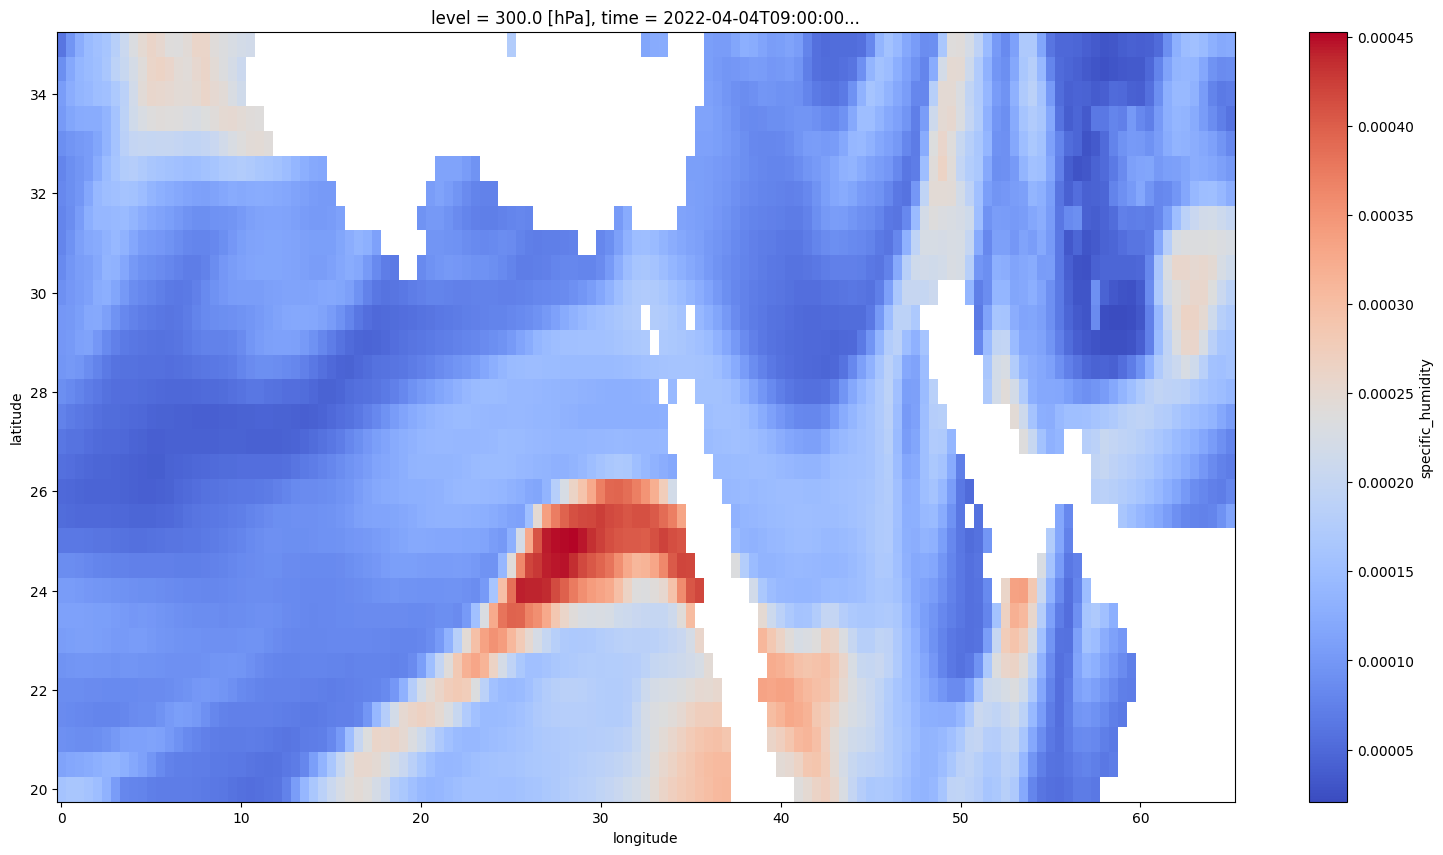

In [ ]:
datasetValid['specific_humidity'].data.isel(time=0).plot(x="longitude", y='latitude', cmap='coolwarm', figsize=(figx, figy))

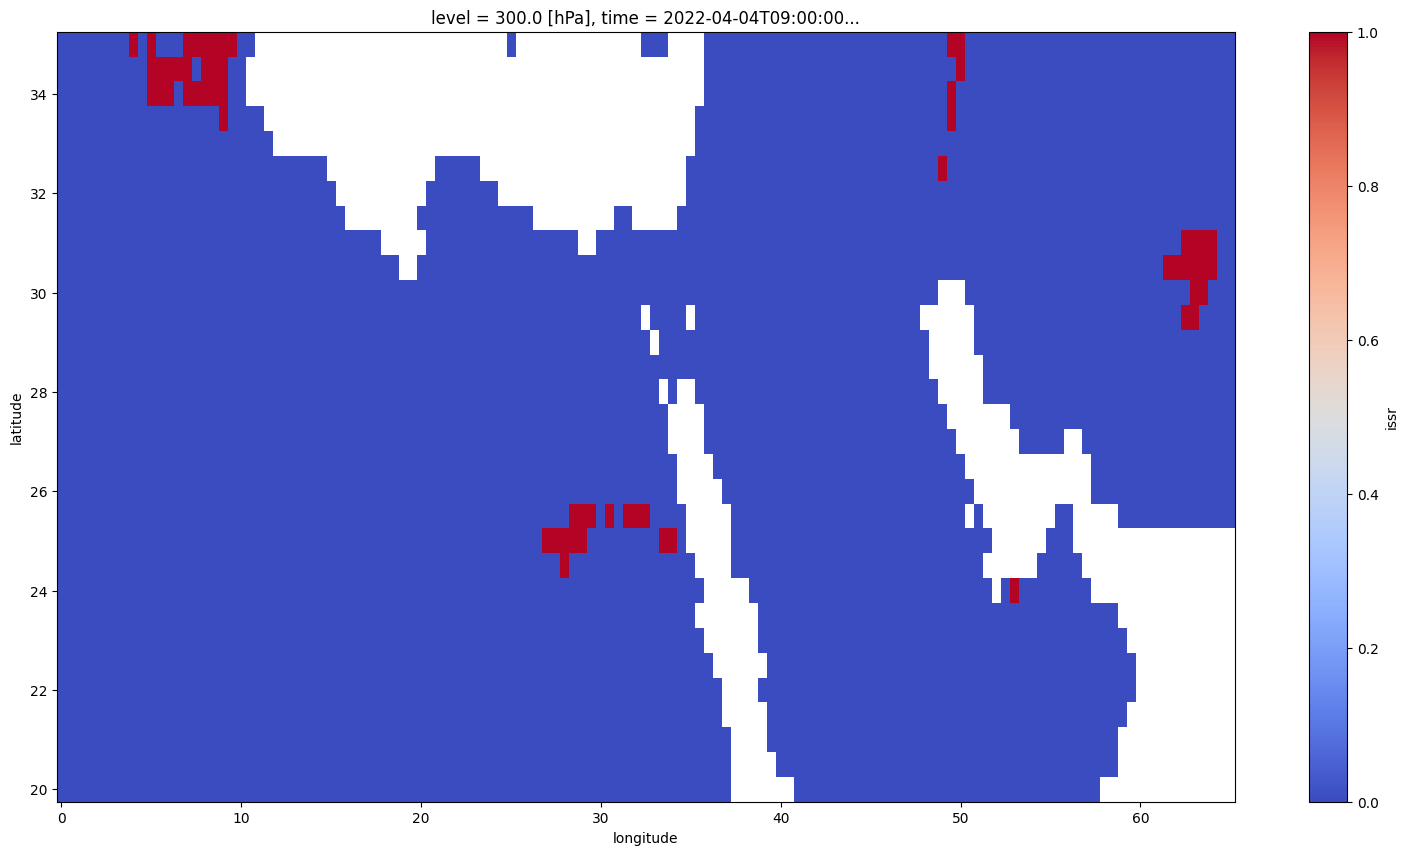

In [153]:
issrPred.isel(time=0).plot(x="longitude", y='latitude', cmap='coolwarm', figsize=(figx, figy))

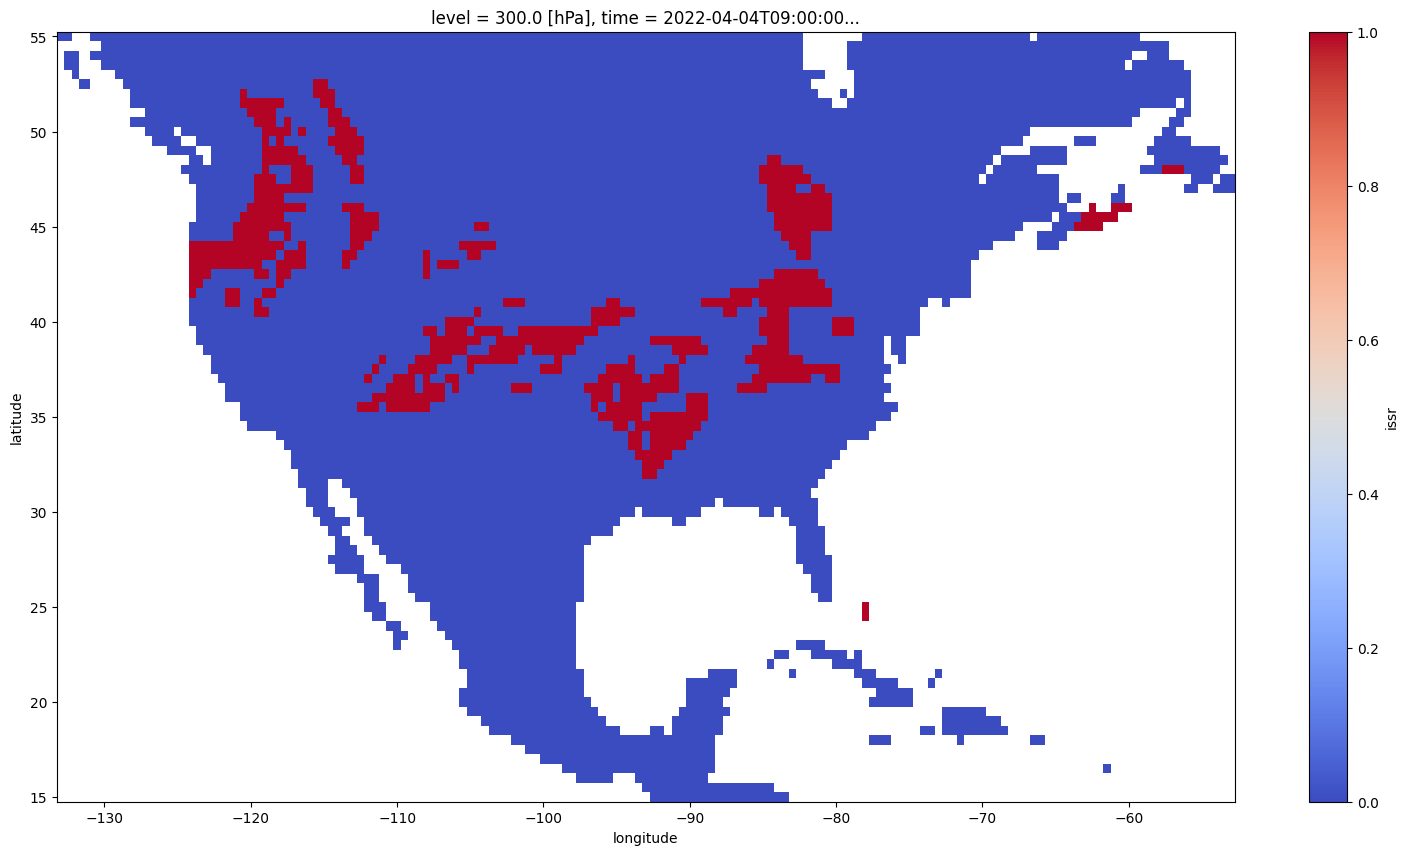

In [ ]:
issrValid.isel(time=0).plot(x="longitude", y='latitude', cmap='coolwarm', figsize=(figx, figy))


In [ ]:
processedData['skt']

<xarray.DataArray 'skt' (time: 6, latitude: 1801, longitude: 3600)>
[38901600 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 2022-04-01T09:00:00 ... 2022-04-06T09:00:00
Attributes:
    units:      K
    long_name:  Skin temperature

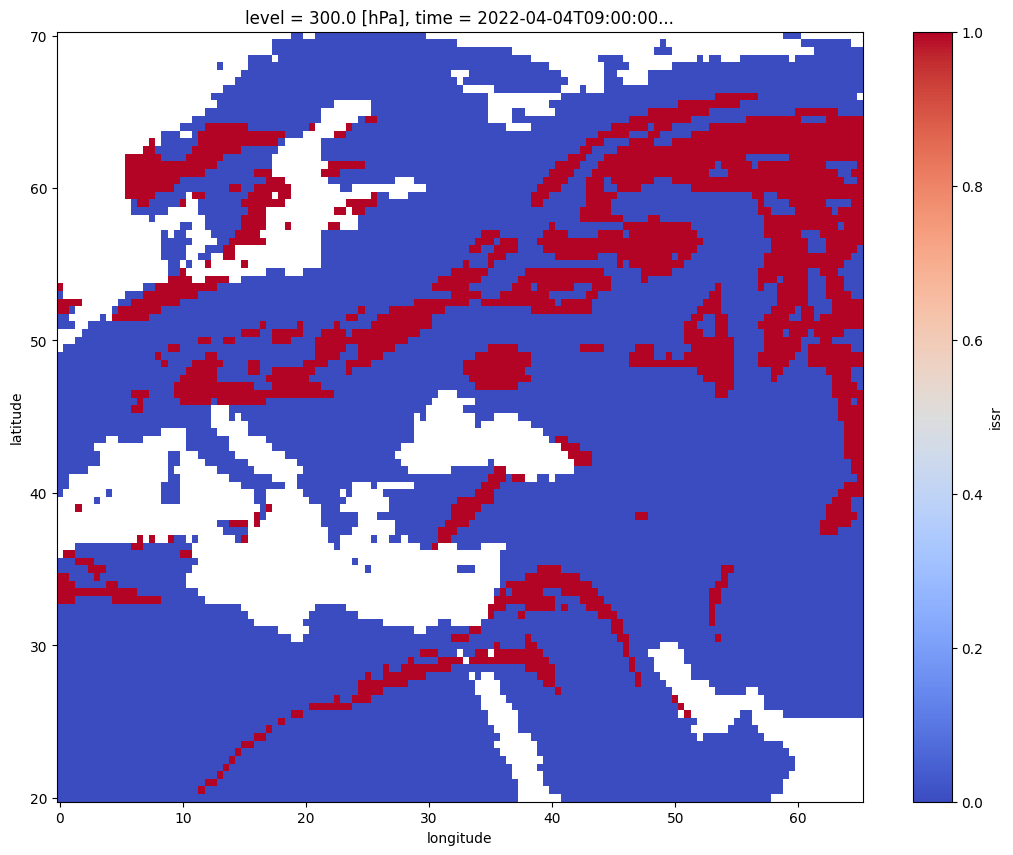

In [ ]:
#sac pred plot
issrInput['issr'].data.plot(x="longitude", y='latitude', cmap='coolwarm', figsize=(figx, figy))

In [ ]:
#sac valid plot
SCVG.plot(x="longitude", y='latitude', row='level', cmap='reds', figsize=(figx, figy))

In [ ]:
#issr pred plot
ICPG.plot(x="longitude", y='latitude', row='level', cmap='reds', figsize=(figx, figy))

In [ ]:
#issr valid plot
ICVG.plot(x="longitude", y='latitude', row='level', cmap='reds', figsize=(figx, figy))

In [ ]:
del sacPred, sacValid
gc.collect()

34

In [ ]:
processedData = xr.open_dataset('/content/gdrive/MyDrive/Convex/Datasets/era5Land.nc')

In [ ]:
processedData

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 6)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2022-04-01T09:00:00 ... 2022-04-06T09:00:00
Data variables: (12/16)
    d          (time, latitude, longitude) float32 ...
    cc         (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    o3         (time, latitude, longitude) float32 ...
    pv         (time, latitude, longitude) float32 ...
    r          (time, latitude, longitude) float32 ...
    ...         ...
    cswc       (time, latitude, longitude) float32 ...
    t          (time, latitude, longitude) float32 ...
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
    w          (time, latitude, longitude) float32 ...
    vo         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-25 20:38:44 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

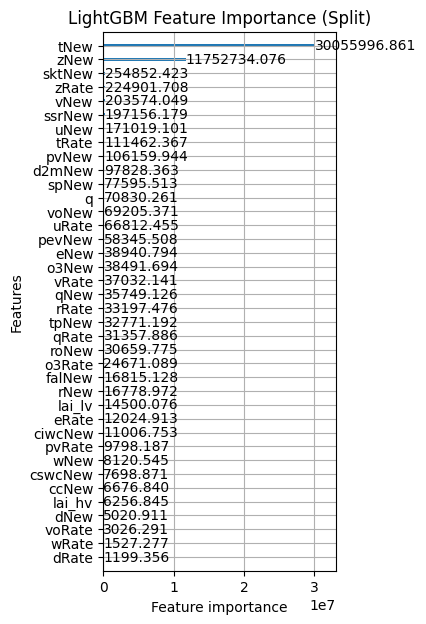

In [ ]:
lgb.plot_importance(bst, importance_type="gain", figsize=(3,7), title="LightGBM Feature Importance (Split)")
plt.show()